In [23]:
from tensorflow.keras.datasets.cifar10 import load_data
from matplotlib import pyplot

import tensorflow as tf

from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten, Conv2DTranspose, Dense, Dropout, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from numpy import expand_dims, ones, zeros
from numpy.random import randn, randint

import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TFCPPMINLOGLEVEL'] = '1'

In [3]:
(x_train, y_train), (x_test, y_test) = load_data()

print(f"Treinamento: {x_train.shape} {y_train.shape}\nTeste: {x_test.shape} {y_test.shape}")

Treinamento: (50000, 32, 32, 3) (50000, 1)
Teste: (10000, 32, 32, 3) (10000, 1)


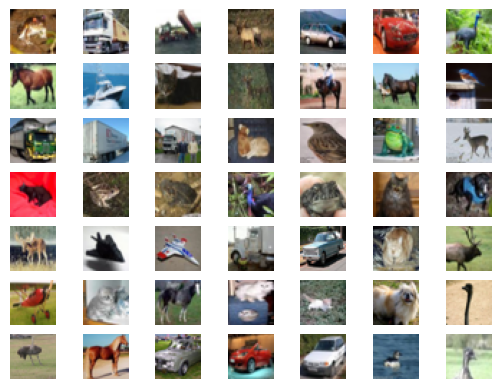

In [4]:
for i in range(49):
    pyplot.subplot(7, 7, 1 + i)
    pyplot.axis("off")
    pyplot.imshow(x_train[i])
pyplot.show()

In [5]:
def discriminator(in_shape = (32,32,3)):
    model = Sequential([
        Conv2D(64, (3, 3), padding = "same", input_shape = in_shape),
        LeakyReLU(alpha = 0.2),
        Conv2D(128, (3, 3), strides = (2, 2), padding = "same"),
        LeakyReLU(alpha = 0.2),
        Conv2D(128, (3, 3), strides = (2, 2), padding = "same"),
        LeakyReLU(alpha = 0.2),
        Conv2D(256, (3, 3), strides = (2, 2), padding = "same"),
        LeakyReLU(alpha = 0.2),
        Flatten(),
        Dropout(0.4),
        Dense(1, activation = "sigmoid")
    ])

    optimizer = tf.keras.optimizers.Adam(lr = 0.002)
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

    return model

In [6]:
def load_real_samples():
    (x_train, _), (_,_) = load_data()
    x = x_train.astype("float32")
    x = (x - 127.5) / 127.5
    return x


In [11]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    x = dataset[ix]
    y = ones((n_samples))
    return (x, y)

In [12]:
def generate_fake_samples(n_samples):
    x = randn(32*32*3*n_samples)
    x = -1 + x * 2
    x = x.reshape((n_samples, 32, 32, 3))
    y = zeros((n_samples, 1))
    return (x, y)

In [13]:
def train_discriminator(model, dataset, n_iter = 20, n_batch = 128):
    half_batch = int(n_batch/2)
    for i in range(n_iter):
        x_real, y_real = generate_real_samples(dataset, half_batch)
        _, real_acc = model.train_on_batch(x_real, y_real)
        x_falso, y_falso = generate_fake_samples(half_batch)
        _, fake_acc = model.train_on_batch(x_falso, y_falso)
        print(">%d real = %.0f%% fake = %.0f%%" % (i+1, real_acc * 100, fake_acc * 100))


In [14]:
model = discriminator()
dataset = load_real_samples()
train_discriminator(model, dataset)

>1 real = 66% fake = 0%
>2 real = 94% fake = 89%
>3 real = 36% fake = 100%
>4 real = 50% fake = 100%
>5 real = 59% fake = 100%
>6 real = 83% fake = 100%
>7 real = 89% fake = 100%
>8 real = 98% fake = 100%
>9 real = 97% fake = 100%
>10 real = 100% fake = 100%
>11 real = 98% fake = 100%
>12 real = 100% fake = 100%
>13 real = 100% fake = 100%
>14 real = 100% fake = 100%
>15 real = 100% fake = 100%
>16 real = 100% fake = 100%
>17 real = 100% fake = 100%
>18 real = 100% fake = 100%
>19 real = 100% fake = 100%
>20 real = 100% fake = 100%


In [15]:
def generator(latent_dim):
    n_nodes = 256*4*4

    model = Sequential([
        Dense(n_nodes, input_dim = latent_dim),
        LeakyReLU(alpha = 0.2),
        Reshape((4, 4, 256)),
        Conv2DTranspose(128, (4, 4), strides = (2, 2), padding = "same"),
        LeakyReLU(alpha = 0.2),
        Conv2DTranspose(128, (4, 4), strides = (2, 2), padding = "same"),
        LeakyReLU(alpha = 0.2),
        Conv2DTranspose(128, (4, 4), strides = (2, 2), padding = "same"),
        LeakyReLU(alpha = 0.2),
        Conv2D(3, (3,3), activation = "tanh", padding = "same")
    ])

    return model

In [16]:
def generate_latent_points(latent_dim, n_samples):
    x_input_l = randn(latent_dim * n_samples)
    x_input_l = x_input_l.reshape(n_samples, latent_dim)
    return x_input_l

In [17]:
def fake_sampler(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    x = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return (x, y)

In [18]:
latent_dim = 100

model = generator(latent_dim)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

2/2 [==============================] - 0s 50ms/step


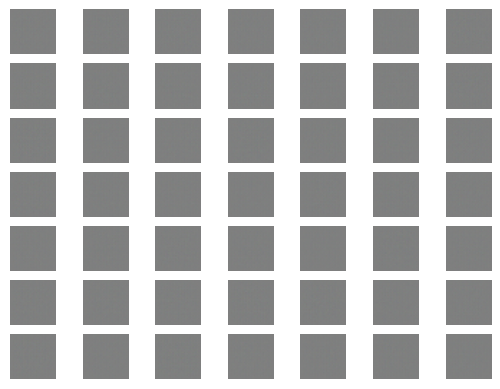

In [19]:
n_samples = 49
x, _ = fake_sampler(model, latent_dim, n_samples)
x = (x+1) / 2.0

for i in range(n_samples):
    pyplot.subplot(7,7,1+i)
    pyplot.axis("off")
    pyplot.imshow(x[i])

pyplot.show()

In [20]:
def gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential([
        g_model,
        d_model
    ])

    opt = tf.keras.optimizers.Adam(lr = 0.0002)
    model.compile(loss = "binary_crossentropy", optimizer = opt)
    return model

In [24]:
latent_dim = 100
d_model = discriminator()
g_model = generator(latent_dim)
gan_model = gan(g_model=g_model, d_model=d_model)
gan_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential_6 (Sequential)   (None, 1)                 387201    
                                                                 
Total params: 1,853,316
Trainable params: 1,466,115
Non-trainable params: 387,201
_________________________________________________________________
